In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
import category_encoders as ce

from sklearn.model_selection import train_test_split

In [4]:
def target_encode_multiclass(X, y, features, target_name): 
    """Target encoding for multiclass classification problems
    
    x : pd.DataFrame 
    y : pd.DataFrame
    features : list
    target_name : str
    """

    y=y.astype(str)
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)

    y_onehot.columns = y[target_name].unique()
    y_onehot=y_onehot[y_onehot.columns.sort_values()]

    X_obj=X[features].astype(str)
    
    feat_target_enc_df = pd.DataFrame([])
    
    for class_ in y_onehot.columns:

        enc=ce.TargetEncoder()
        enc.fit(X_obj, y_onehot[class_])

        fet_target_enc=enc.transform(X_obj)
        fet_target_enc.columns=[str(x)+'_'+str(class_) for x in fet_target_enc.columns]
        
        feat_target_enc_df = pd.concat([feat_target_enc_df, fet_target_enc], 1)
        
    return feat_target_enc_df

def print_classes(y):
    num_inst = y.shape[0]
    classes_order = np.unique(y.damage_grade)
    print("There are {} instances".format(num_inst))
    print("Absolute count".format(num_inst))
    print((y.damage_grade.value_counts()[classes_order]).to_markdown())    
    print("Relative count".format(num_inst))
    print((y.damage_grade.value_counts()[classes_order] / num_inst).to_markdown())

def piece_wise_resampling(x, y, resampler=None, num_iter=None):
    splitted_indexes = np.array_split(x.index, num_iter)

    x_resampled = []
    y_resampled = []

    for i in tqdm(range(num_iter)):
        x_resampled_t, y_resampled_t = resampler.fit_resample(x.loc[splitted_indexes[i]], 
                                                              y.loc[splitted_indexes[i]])
        x_resampled.append(x_resampled_t)
        y_resampled.append(y_resampled_t)

    return pd.concat(x_resampled), pd.concat(y_resampled)

# 1.1 Load data

In [100]:
build_owner_info = pd.read_csv('raw_data/buildings_data/csv_building_ownership_and_use.csv')
build_struct_info = pd.read_csv('raw_data/buildings_data/csv_building_structure.csv')

The datasets have the same number of instances and all report a 'building_id' identifier. This has been checked to be consistent for the two datasets, and so it is used as index:

In [101]:
build_owner_info = build_owner_info.set_index('building_id').sort_index()
build_struct_info = build_struct_info.set_index('building_id').sort_index()

In [108]:
build_owner_info.head()

,district_id,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
120101000021,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
120101000031,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
120101000041,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
120101000051,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


In [109]:
build_struct_info.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,1,0,0,0,Grade 3
120101000021,12,1207,120703,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,1,0,0,0,Grade 5
120101000031,12,1207,120703,1,20,384,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,Grade 2
120101000041,12,1207,120703,1,20,312,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,Grade 2
120101000051,12,1207,120703,1,30,308,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,Grade 1


Let's look to the building structural features more in details:

In [102]:
build_struct_info.columns.tolist()

['district_id',
 'vdcmun_id',
 'ward_id',
 'count_floors_pre_eq',
 'count_floors_post_eq',
 'age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'height_ft_post_eq',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'condition_post_eq',
 'damage_grade',
 'technical_solution_proposed']

In [103]:
build_struct_info = build_struct_info.drop(columns = ['height_ft_post_eq', 
                                                      'count_floors_post_eq', 
                                                      'condition_post_eq', 
                                                     'technical_solution_proposed'])

In [168]:
data = pd.concat([build_struct_info, 
                  build_owner_info.drop(columns=['district_id', 'vdcmun_id', 'ward_id'])], 1)

In [169]:
data.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,0
120101000021,12,1207,120703,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,0
120101000031,12,1207,120703,1,20,384,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,0
120101000041,12,1207,120703,1,20,312,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,0
120101000051,12,1207,120703,1,30,308,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,0


In [114]:
data_values.shape

(762106, 39)

In [267]:
x, y = data.drop(columns="damage_grade"), data[["damage_grade"]]

In [268]:
no_target = y[y.isna().values]

x = x.drop(index=no_target.index)
y = y.drop(index=no_target.index)

In [269]:
# Replace blank space with underscore
y = pd.DataFrame(y.apply(lambda row: '{}_{}'.format(row.damage_grade.split(' ')[0],
                                                    row.damage_grade.split(' ')[1]),1), columns=["damage_grade"])

In [270]:
y

,damage_grade
building_id,
120101000011,Grade_3
120101000021,Grade_5
120101000031,Grade_2
120101000041,Grade_2
120101000051,Grade_1
...,...
366709001241,Grade_5
366709001251,Grade_5
366709001261,Grade_5


## 1.1 Transform categorical variables:

## 1.1.1 Transform high-cardinality variables using target impact encoding:

- https://towardsdatascience.com/all-about-target-encoding-d356c4e9e82
- https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53
- https://dl.acm.org/doi/pdf/10.1145/507533.507538?casa_token=FYbHKRC7Xn0AAAAA:NZEuzb0s5HPLYDZ93wW3-K-Tlfd_lLENkVLCAhmXVa9KdxFcJggzeOq5y6pAqcLcMMAI0fAyqyY

In [322]:
feat_target_encoded = target_encode_multiclass(x, y, ['district_id', 'vdcmun_id', 'ward_id'], 'damage_grade')

C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\aleciu\Anaconda

In [329]:
x  = pd.concat([feat_target_encoded, 
               x.drop(columns=['district_id', 'vdcmun_id', 'ward_id'])],1)
x.head()

,district_id_Grade_1,vdcmun_id_Grade_1,ward_id_Grade_1,district_id_Grade_2,vdcmun_id_Grade_2,ward_id_Grade_2,district_id_Grade_3,vdcmun_id_Grade_3,ward_id_Grade_3,district_id_Grade_4,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,0.202302,0.343533,0.455182,0.218667,0.244022,0.205882,0.234296,0.231551,0.215686,0.201921,...,0,0,0,0,0,0,0,0,0,0
120101000021,0.202302,0.343533,0.455182,0.218667,0.244022,0.205882,0.234296,0.231551,0.215686,0.201921,...,0,0,0,0,0,0,0,0,0,0
120101000031,0.202302,0.343533,0.455182,0.218667,0.244022,0.205882,0.234296,0.231551,0.215686,0.201921,...,0,0,0,0,0,0,0,0,0,0
120101000041,0.202302,0.343533,0.455182,0.218667,0.244022,0.205882,0.234296,0.231551,0.215686,0.201921,...,0,0,0,0,0,0,0,0,0,0
120101000051,0.202302,0.343533,0.455182,0.218667,0.244022,0.205882,0.234296,0.231551,0.215686,0.201921,...,0,0,0,0,0,0,0,0,0,0


## 1.1.2 Transform low-cardinality variables using one-hot econding:

In [330]:
low_cat = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
            'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

The keys in the following dict allow mapping values of each categorical variable in the hot-encoded data:

In [348]:
for cat in low_cat:
    print({cat: dict(zip(range(1,len(x[cat].unique())+1), x[cat].unique()))})

{'land_surface_condition': {1: 'Flat', 2: 'Moderate slope', 3: 'Steep slope'}}
{'foundation_type': {1: 'Other', 2: 'Mud mortar-Stone/Brick', 3: 'Cement-Stone/Brick', 4: 'Bamboo/Timber', 5: 'RC'}}
{'roof_type': {1: 'Bamboo/Timber-Light roof', 2: 'Bamboo/Timber-Heavy roof', 3: 'RCC/RB/RBC'}}
{'ground_floor_type': {1: 'Mud', 2: 'Brick/Stone', 3: 'RC', 4: 'Timber', 5: 'Other'}}
{'other_floor_type': {1: 'Not applicable', 2: 'TImber/Bamboo-Mud', 3: 'Timber-Planck', 4: 'RCC/RB/RBC'}}
{'position': {1: 'Not attached', 2: 'Attached-1 side', 3: 'Attached-2 side', 4: 'Attached-3 side'}}
{'plan_configuration': {1: 'Rectangular', 2: 'L-shape', 3: 'Square', 4: 'T-shape', 5: 'Multi-projected', 6: 'H-shape', 7: 'U-shape', 8: 'Others', 9: 'E-shape', 10: 'Building with Central Courtyard'}}
{'legal_ownership_status': {1: 'Private', 2: 'Other', 3: 'Institutional', 4: 'Public'}}


In [333]:
enc=ce.OneHotEncoder().fit(x[low_cat])
x_lowcat_onehot=enc.transform(x[low_cat])

C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


For instance, we expect all ones at 'land_surface_condition_3' when land_surface_condition = 'Steep slope'

In [352]:
x_lowcat_onehot[x['land_surface_condition'] == 'Steep slope']

,land_surface_condition_1,land_surface_condition_2,land_surface_condition_3,foundation_type_1,foundation_type_2,foundation_type_3,foundation_type_4,foundation_type_5,roof_type_1,roof_type_2,...,plan_configuration_5,plan_configuration_6,plan_configuration_7,plan_configuration_8,plan_configuration_9,plan_configuration_10,legal_ownership_status_1,legal_ownership_status_2,legal_ownership_status_3,legal_ownership_status_4
building_id,,,,,,,,,,,,,,,,,,,,,
120302000021,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
120302000031,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
120302000041,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
120302000051,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
120302000061,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366608000481,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
366608000551,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
366608000561,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [354]:
x = pd.concat([x.drop(columns=low_cat), x_lowcat_onehot], 1)

## Check for remaining nans:

In [32]:
i,j=np.where(np.isnan(x))
print('Nan in {}'.format(x.columns[j].values[0]))

Nan in count_families


In [33]:
x.iloc[i,j] = x.iloc[:,j].mean().values[0]

In [3]:
x = pd.read_csv('processed_data/x_post_preproc.csv', index_col='building_id')
y = pd.read_csv('processed_data/y_post_preproc.csv', index_col='building_id')

In [4]:
print_classes(y)

There are 762094 instances
Absolute count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |          78815 |
| Grade_2 |          87257 |
| Grade_3 |         136412 |
| Grade_4 |         183844 |
| Grade_5 |         275766 |
Relative count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |       0.103419 |
| Grade_2 |       0.114496 |
| Grade_3 |       0.178996 |
| Grade_4 |       0.241235 |
| Grade_5 |       0.361853 |


In [16]:
map_grades = {'Grade_1': 'G1', 'Grade_2': 'G1',
              'Grade_3': 'G2', 'Grade_4': 'G2', 'Grade_5': 'G3'}

y3labs = pd.DataFrame(y.apply(lambda row: map_grades[row["damage_grade"]], 1), columns=['damage_grade'])

print_classes(y3labs)

There are 762094 instances
Absolute count
|    |   damage_grade |
|:---|---------------:|
| G1 |         166072 |
| G2 |         320256 |
| G3 |         275766 |
Relative count
|    |   damage_grade |
|:---|---------------:|
| G1 |       0.217915 |
| G2 |       0.420232 |
| G3 |       0.361853 |


In [17]:
y3labs.to_csv('y_post_preproc_3lab.csv')

## 2.1.2 Rebalance training data:

- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- https://imbalanced-learn.org/stable/combine.html
- https://imbalanced-learn.org/stable/auto_examples/combine/plot_comparison_combine.html#sphx-glr-auto-examples-combine-plot-comparison-combine-py

In [7]:
x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)
y_train, y_test = y.loc[x_train.index], y.loc[x_test.index]

In [186]:
print_classes(y_train)

There are 609675 instances
Absolute count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |          63007 |
| Grade_2 |          69799 |
| Grade_3 |         109199 |
| Grade_4 |         146850 |
| Grade_5 |         220820 |
Relative count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |       0.103345 |
| Grade_2 |       0.114486 |
| Grade_3 |       0.17911  |
| Grade_4 |       0.240866 |
| Grade_5 |       0.362193 |


## 2.1.2.1 Over-sampling with SMOTENC

In [8]:
numeric_features = ['height_ft_pre_eq', 'plinth_area_sq_ft', 'age_building',
                    'count_floors_pre_eq', 'count_families']

cat_feat_id = [i for i in range(x_train.columns.shape[0]) if x_train.columns[i] not in numeric_features]

In [12]:
sm = SMOTENC(categorical_features=cat_feat_id, random_state = 27, n_jobs = -1)

In [ ]:
x_train_smote_nc, y_train_smote_nc = piece_wise_resampling(x_train, y_train, sm, 200)

In [77]:
x_train_smotenc = pd.read_csv('processed_data/resampling/x_train_smotenc.csv', index_col=0).reset_index(drop=True)
y_train_smotenc = pd.read_csv('processed_data/resampling/y_train_smotenc.csv', index_col=0).reset_index(drop=True)

C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2.1.2.2 Under-sampling: cleaning dataset

## 2.1.2.1 Tomek

In [80]:
tmk = TomekLinks(sampling_strategy='all', n_jobs=2)
enn = EditedNearestNeighbours(kind_sel='mode', sampling_strategy='all', n_jobs=2)

In [117]:
x_train_smotenc_tmk, y_train_smotenc_tmk = piece_wise_resampling(x_train_smotenc, y_train_smotenc, tmk, 50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [18:02<00:00, 21.66s/it]


In [130]:
print_classes(y_train_smotenc_tmk)

There are 897616 instances
Absolute count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |         198969 |
| Grade_2 |         183975 |
| Grade_3 |         174207 |
| Grade_4 |         169016 |
| Grade_5 |         171449 |
Relative count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |       0.221664 |
| Grade_2 |       0.20496  |
| Grade_3 |       0.194077 |
| Grade_4 |       0.188294 |
| Grade_5 |       0.191005 |


In [131]:
x_train_smotenc_tmk.to_csv('processed_data/resampling/x_train_smotenc_tmk.csv')
y_train_smotenc_tmk.to_csv('processed_data/resampling/y_train_smotenc_tmk.csv')

## 2.1.2.1 ENN

In [133]:
x_train_smotenc_enn, y_train_smotenc_enn = piece_wise_resampling(x_train_smotenc, y_train_smotenc, enn, 50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [22:54<00:00, 27.50s/it]


In [134]:
print_classes(y_train_smotenc_enn)

There are 526650 instances
Absolute count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |         170370 |
| Grade_2 |         132390 |
| Grade_3 |         100224 |
| Grade_4 |          72822 |
| Grade_5 |          50844 |
Relative count
|         |   damage_grade |
|:--------|---------------:|
| Grade_1 |      0.323498  |
| Grade_2 |      0.251381  |
| Grade_3 |      0.190305  |
| Grade_4 |      0.138274  |
| Grade_5 |      0.0965423 |


In [135]:
x_train_smotenc_enn.to_csv('processed_data/resampling/x_train_smotenc_enn.csv')
y_train_smotenc_enn.to_csv('processed_data/resampling/y_train_smotenc_enn.csv')

### 3. Plot data imbalances

In [5]:
x = pd.read_csv('../Project_data/processed_data/x_post_preproc.csv', index_col='building_id')
y = pd.read_csv('../Project_data/processed_data/y_post_preproc.csv', index_col='building_id')

In [8]:
x_train, _ = train_test_split(x, test_size=0.2, random_state=42)
y_train_orig = y.loc[x_train.index]

In [128]:
y_train_smotenc = pd.read_csv('../Project_data/processed_data/resampling/y_train_smotenc.csv', index_col=0).reset_index(drop=True)
y_train_tmk = pd.read_csv('../Project_data/processed_data/resampling/y_train_smotenc_tmk.csv', index_col=0).reset_index(drop=True)
y_train_enn = pd.read_csv('../Project_data/processed_data/resampling/y_train_smotenc_enn.csv', index_col=0).reset_index(drop=True)

C:\Users\aleciu\Anaconda3\envs\ml\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
x = pd.read_csv('../Project_data/processed_data/x_post_preproc.csv', index_col='building_id')
y = pd.read_csv('../Project_data/processed_data/y_post_preproc_3lab.csv', index_col='building_id')

In [11]:
x_train, _ = train_test_split(x, test_size=0.2, random_state=42)
y_train_3cls = y.loc[x_train.index]

In [80]:
import seaborn as sns

In [129]:
classes_5 = np.unique(y_train_orig)
df_imb = pd.DataFrame(columns=['fraction', 'class', 'sampling_type'])

train_sets_types = ['orig', 'smotenc', 'smotenc_tmk', 'smotenc_enn']
train_sets = [y_train_orig, y_train_smotenc, y_train_tmk, y_train_enn]

for i in range(len(train_sets)):
    fracs = train_sets[i].value_counts(normalize=True)[classes_5.tolist()].values

    temp_df = pd.DataFrame([fracs, classes_5], index=['fraction', 'class']).T
    temp_df['sampling_type'] = train_sets_types[i]

    df_imb = pd.concat([df_imb, temp_df])

In [130]:
classes_3 = np.unique(y_train_3cls)
fracs = y_train_3cls.value_counts(normalize=True)[classes_3.tolist()].values
df_imb3 = pd.DataFrame([fracs, classes_3], index=['fraction', 'class']).T

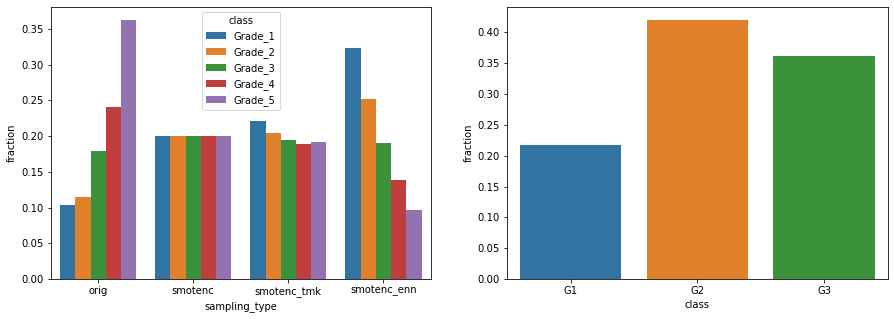

In [136]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.barplot(ax=ax[0], data=df_imb, x='sampling_type', y='fraction', hue='class')
sns.barplot(ax=ax[1], data=df_imb3, y='fraction', x='class')

#fig.savefig('results/figs/data_imbalance.png', bbox_inches='tight')

In [134]:
sizes = [y.shape[0] for y in train_sets]

df_sizes = pd.DataFrame(sizes, columns=['training size'], index=train_sets_types).T
df_sizes

,orig,smotenc,smotenc_tmk,smotenc_enn
training size,609675,1104100,897616,526650


In [137]:
#df_sizes.to_excel('results/sets_sizes.xlsx')